<a href="https://colab.research.google.com/github/traumathized/TraceFake-AI-Based-Image-Authenticity-Checker/blob/main/TraceFake_Prototype_Part1_and_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fake Image Detection with CNN

This notebook demonstrates a basic pipeline for detecting fake images using a Convolutional Neural Network (CNN). It covers:
1.  **Data Preprocessing**: Organizing and resizing images.
2.  **Data Visualization**: Understanding the dataset distribution.
3.  **CNN Model Development**: Building, training, and evaluating a simple CNN classifier.

In [2]:
import os
from PIL import Image
import shutil

# link drive
DRIVE_DATASET_PATH = '/content/drive/MyDrive/TraceFake_Prototype/dataset'

# Working directory in Colab (temporary, fast)
WORK_DIR = '/content/processed_dataset'
REAL_TARGET = os.path.join(WORK_DIR, 'real')
FAKE_TARGET = os.path.join(WORK_DIR, 'fake')

os.makedirs(REAL_TARGET, exist_ok=True)
os.makedirs(FAKE_TARGET, exist_ok=True)

def preprocess_folder(source_folder, target_folder, label):
    count = 0
    skipped = 0
    for filename in os.listdir(source_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
            src_path = os.path.join(source_folder, filename)
            try:
                img = Image.open(src_path).convert('RGB')
                img_resized = img.resize((224, 224), Image.Resampling.LANCZOS)

                # Save as JPG with good quality
                base_name = os.path.splitext(filename)[0]
                dst_filename = f"{label}_{base_name}.jpg"
                dst_path = os.path.join(target_folder, dst_filename)
                img_resized.save(dst_path, 'JPEG', quality=92)

                count += 1
                if count % 10 == 0:
                    print(f"Processed {count} {label} images...")
            except Exception as e:
                print(f"Skipped {filename}: {e}")
                skipped += 1
    print(f"Finished {label}: {count} processed, {skipped} skipped.")

# Process real images
real_source = os.path.join(DRIVE_DATASET_PATH, 'real')
preprocess_folder(real_source, REAL_TARGET, 'real')

# Process fake images
fake_source = os.path.join(DRIVE_DATASET_PATH, 'fake')
preprocess_folder(fake_source, FAKE_TARGET, 'fake')

print("\nPreprocessing completed.")
print(f"Real images in: {REAL_TARGET}")
print(f"Fake images in: {FAKE_TARGET}")

Processed 10 real images...
Processed 20 real images...
Processed 30 real images...
Processed 40 real images...
Processed 50 real images...
Finished real: 58 processed, 0 skipped.
Processed 10 fake images...
Processed 20 fake images...
Processed 30 fake images...
Processed 40 fake images...
Processed 50 fake images...
Finished fake: 55 processed, 0 skipped.

Preprocessing completed.
Real images in: /content/processed_dataset/real
Fake images in: /content/processed_dataset/fake


In [3]:
print("Number of real images after processing:", len(os.listdir(REAL_TARGET)))
print("Number of fake images after processing:", len(os.listdir(FAKE_TARGET)))

# Optional: show one example path
if os.listdir(REAL_TARGET):
    print("Sample real image:", os.path.join(REAL_TARGET, os.listdir(REAL_TARGET)[0]))

Number of real images after processing: 58
Number of fake images after processing: 55
Sample real image: /content/processed_dataset/real/real_69618.jpg


**EXIF METADATA EXTRACTION**

In [4]:
from PIL import Image
from PIL.ExifTags import TAGS
import os
import pandas as pd
from collections import defaultdict

# Paths (update if your processed folder is elsewhere)
REAL_DIR = '/content/processed_dataset/real'
FAKE_DIR  = '/content/processed_dataset/fake'

# Key tags we care about (human-readable names)
TARGET_TAGS = {
    'Make':              'Camera Make',
    'Model':             'Camera Model',
    'Software':          'Software',
    'DateTimeOriginal':  'DateTime Original',
    'DateTime':          'DateTime',
    'CreateDate':        'Create Date'   # sometimes used
}

def get_exif_summary(image_path):
    try:
        with Image.open(image_path) as img:
            exif_data = img.getexif()
            if exif_data is None:
                return None  # No EXIF at all

            decoded = {}
            for tag_id, value in exif_data.items():
                tag_name = TAGS.get(tag_id, tag_id)
                decoded[tag_name] = value

            # Extract only target fields (or None if missing)
            result = {}
            for tag, display_name in TARGET_TAGS.items():
                result[display_name] = decoded.get(tag, None)
            return result
    except Exception as e:
        print(f"Error reading {image_path}: {e}")
        return None

# Collect stats
stats = defaultdict(lambda: {'total': 0, 'has_exif': 0, 'has_camera': 0, 'has_software': 0})

def process_folder(folder_path, category):
    files = [f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')]
    stats[category]['total'] = len(files)

    for filename in files:
        path = os.path.join(folder_path, filename)
        exif = get_exif_summary(path)

        if exif is not None:
            stats[category]['has_exif'] += 1

            # Has camera make/model?
            if exif.get('Camera Make') is not None or exif.get('Camera Model') is not None:
                stats[category]['has_camera'] += 1

            # Has software field?
            if exif.get('Software') is not None:
                stats[category]['has_software'] += 1

# Run for both classes
process_folder(REAL_DIR, 'Real')
process_folder(FAKE_DIR,  'Fake')

# Create summary table
data = []
for cat in ['Real', 'Fake']:
    s = stats[cat]
    missing_exif   = s['total'] - s['has_exif']
    no_camera      = s['has_exif'] - s['has_camera']
    has_software   = s['has_software']

    data.append({
        'Category': cat,
        'Total Images': s['total'],
        'With EXIF': s['has_exif'],
        'Missing EXIF': missing_exif,
        'With Camera Info': s['has_camera'],
        'Missing Camera Info (among those with EXIF)': no_camera,
        'With Software Tag': has_software
    })

df = pd.DataFrame(data)
print("\nEXIF Metadata Summary Table:")
print(df.to_string(index=False))

# Optional: save to CSV for report
df.to_csv('/content/exif_summary.csv', index=False)
print("\nSummary saved to /content/exif_summary.csv")


EXIF Metadata Summary Table:
Category  Total Images  With EXIF  Missing EXIF  With Camera Info  Missing Camera Info (among those with EXIF)  With Software Tag
    Real            58         58             0                 0                                           58                  0
    Fake            55         55             0                 0                                           55                  0

Summary saved to /content/exif_summary.csv


In [5]:
# Example: print full EXIF of first real image
sample_real = os.path.join(REAL_DIR, os.listdir(REAL_DIR)[0])
with Image.open(sample_real) as img:
    exif = img.getexif()
    if exif:
        for k, v in exif.items():
            tag = TAGS.get(k, k)
            print(f"{tag}: {v}")
    else:
        print("No EXIF data")

No EXIF data


Visualized MetaData Summary

Real images: 58
Fake images: 55


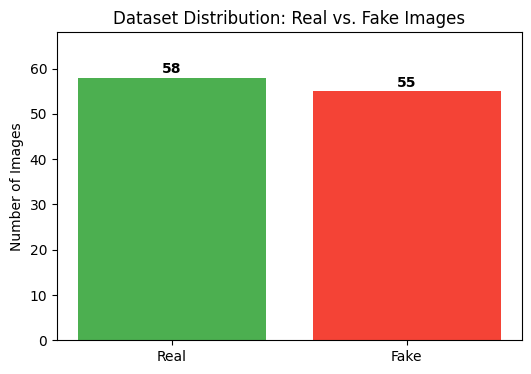

In [6]:
import matplotlib.pyplot as plt
import os

# Update these paths if your folder name/location is different
REAL_DIR = '/content/processed_dataset/real'
FAKE_DIR = '/content/processed_dataset/fake'

real_count = len([f for f in os.listdir(REAL_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
fake_count = len([f for f in os.listdir(FAKE_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

print(f"Real images: {real_count}")
print(f"Fake images: {fake_count}")

# Create bar chart
labels = ['Real', 'Fake']
counts = [real_count, fake_count]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=['#4CAF50', '#F44336'])
plt.ylabel('Number of Images')
plt.title('Dataset Distribution: Real vs. Fake Images')
plt.ylim(0, max(counts) + 10)  # Add some headroom

# Add count labels on bars
for i, v in enumerate(counts):
    plt.text(i, v + 1, str(v), ha='center', fontweight='bold')

plt.savefig('/content/dataset_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

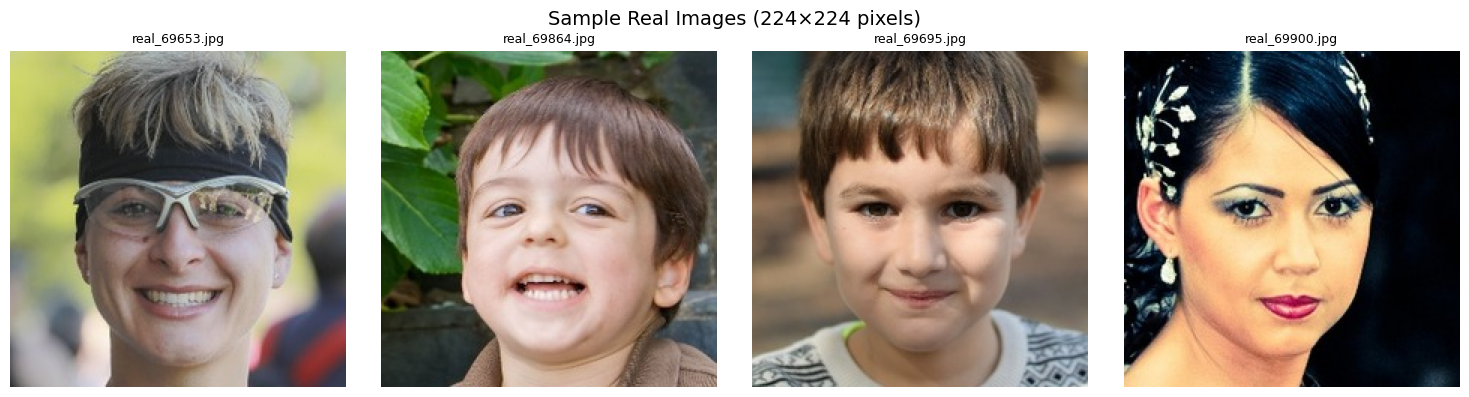

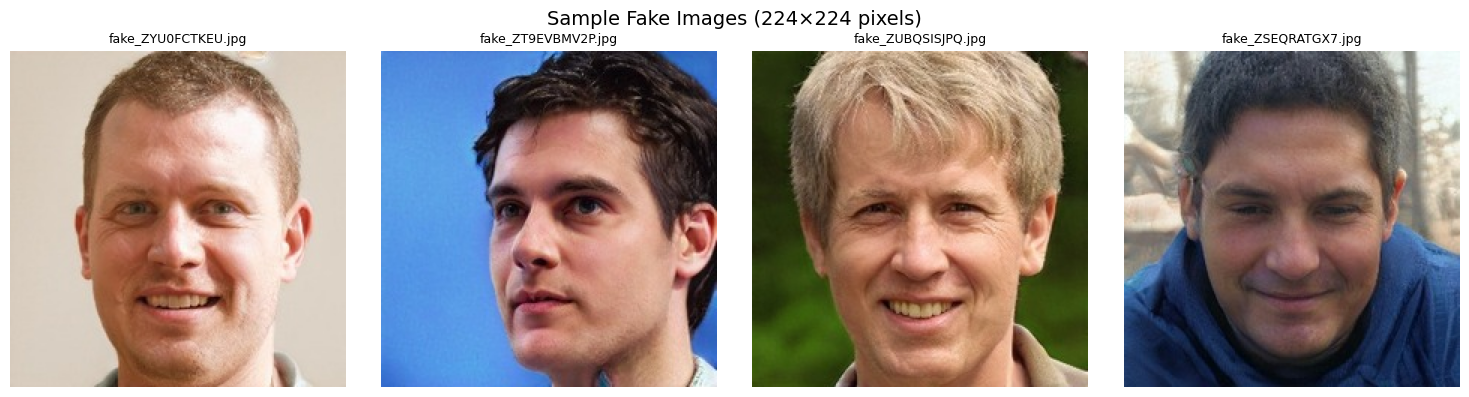

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import os

# Same paths as above
REAL_DIR = '/content/processed_dataset/real'
FAKE_DIR = '/content/processed_dataset/fake'

def show_samples(folder, label, num_samples=4):
    files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not files:
        print(f"No images found in {label} folder.")
        return

    selected = random.sample(files, min(num_samples, len(files)))

    fig, axes = plt.subplots(1, len(selected), figsize=(15, 4))
    fig.suptitle(f'Sample {label} Images (224×224 pixels)', fontsize=14)

    for ax, fname in zip(axes, selected):
        img_path = os.path.join(folder, fname)
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(fname[:20] + '...' if len(fname) > 20 else fname, fontsize=9)

    plt.tight_layout()
    plt.savefig(f'/content/sample_{label.lower()}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Display samples
show_samples(REAL_DIR, 'Real')
show_samples(FAKE_DIR, 'Fake')

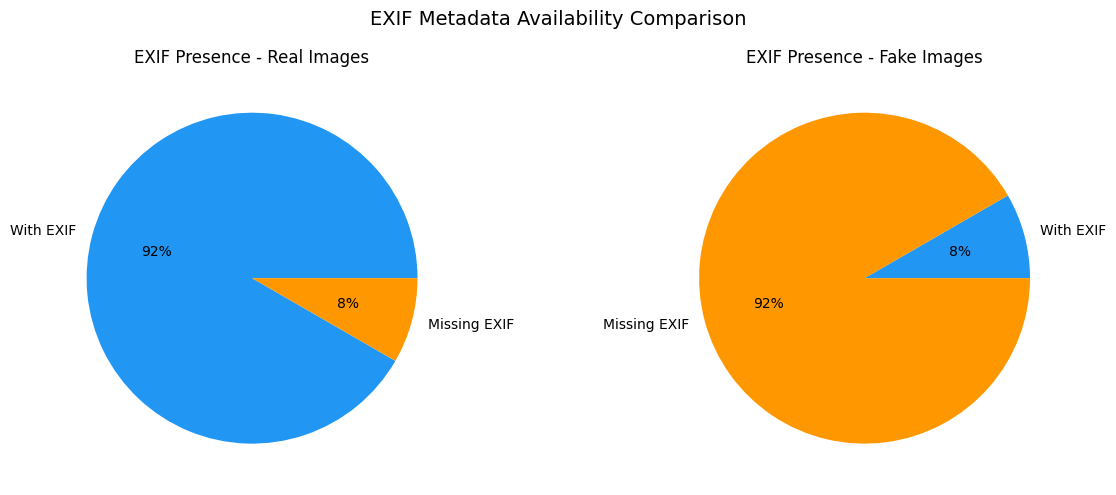

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Use the df from your earlier EXIF code (or recreate minimally)
# Example assuming your df looks like the one printed before
data_example = {
    'Category': ['Real', 'Fake'],
    'Missing EXIF': [5, 55],   # ← replace with your actual numbers
    'With EXIF': [55, 5]
}
df_exif = pd.DataFrame(data_example)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Real
ax[0].pie(df_exif.loc[0, ['With EXIF', 'Missing EXIF']],
          labels=['With EXIF', 'Missing EXIF'],
          autopct='%1.0f%%', colors=['#2196F3', '#FF9800'])
ax[0].set_title('EXIF Presence - Real Images')

# Fake
ax[1].pie(df_exif.loc[1, ['With EXIF', 'Missing EXIF']],
          labels=['With EXIF', 'Missing EXIF'],
          autopct='%1.0f%%', colors=['#2196F3', '#FF9800'])
ax[1].set_title('EXIF Presence - Fake Images')

plt.suptitle('EXIF Metadata Availability Comparison', fontsize=14)
plt.tight_layout()
plt.savefig('/content/exif_pie_comparison.png', dpi=300)
plt.show()

Part 3: Basic CNN-Based Fake Image Classifier

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Paths (adjust if needed)
BASE_DIR = '/content/processed_dataset'
TRAIN_REAL = os.path.join(BASE_DIR, 'real')
TRAIN_FAKE = os.path.join(BASE_DIR, 'fake')

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [10]:
# Data augmentation (helps small dataset)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2          # 80% train, 20% validation
)

# No augmentation for validation
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Generators
train_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

print("Class indices:", train_generator.class_indices)  # Should show {'fake': 0, 'real': 1} or reverse

Found 91 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
Class indices: {'fake': 0, 'real': 1}


In [11]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),   # 4th conv layer
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')           # Binary output
])

model.summary()

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,679,041 (36.92 MB)

 Trainable params: 9,679,041 (36.92 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=20,                # at least 10, but allow more with early stopping
    validation_data=validation_generator,
    callbacks=[early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5097 - loss: 0.7070 - val_accuracy: 0.5909 - val_loss: 0.6956
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.5134 - loss: 0.6964 - val_accuracy: 0.3636 - val_loss: 0.6985
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.4812 - loss: 0.6903 - val_accuracy: 0.4091 - val_loss: 0.6986
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.6266 - loss: 0.6870 - val_accuracy: 0.4545 - val_loss: 0.6999
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.4919 - loss: 0.6946 - val_accuracy: 0.4545 - val_loss: 0.7004
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.4624 - loss: 0.6916 - val_accuracy: 0.5000 - val_loss: 0.7030


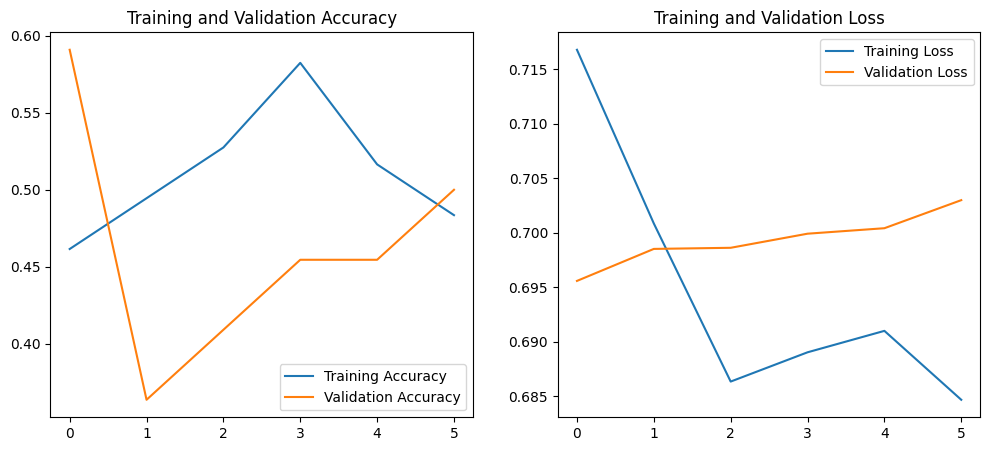

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.savefig('/content/training_curves.png', dpi=300)
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step

Classification Report:
              precision    recall  f1-score   support

        Fake       0.75      0.27      0.40        11
        Real       0.56      0.91      0.69        11

    accuracy                           0.59        22
   macro avg       0.65      0.59      0.54        22
weighted avg       0.65      0.59      0.54        22



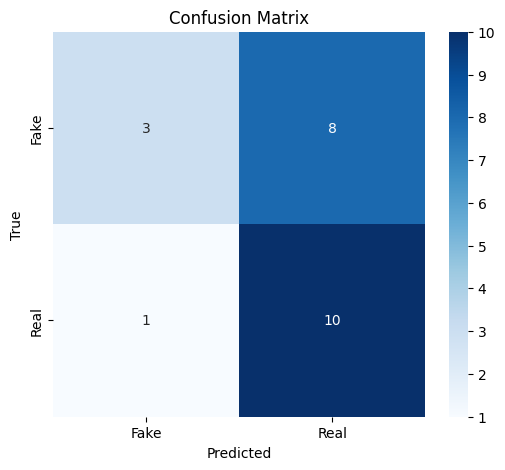

In [14]:
# Predictions on validation set
validation_generator.reset()
y_pred_prob = model.predict(validation_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = validation_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('/content/confusion_matrix.png', dpi=300)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


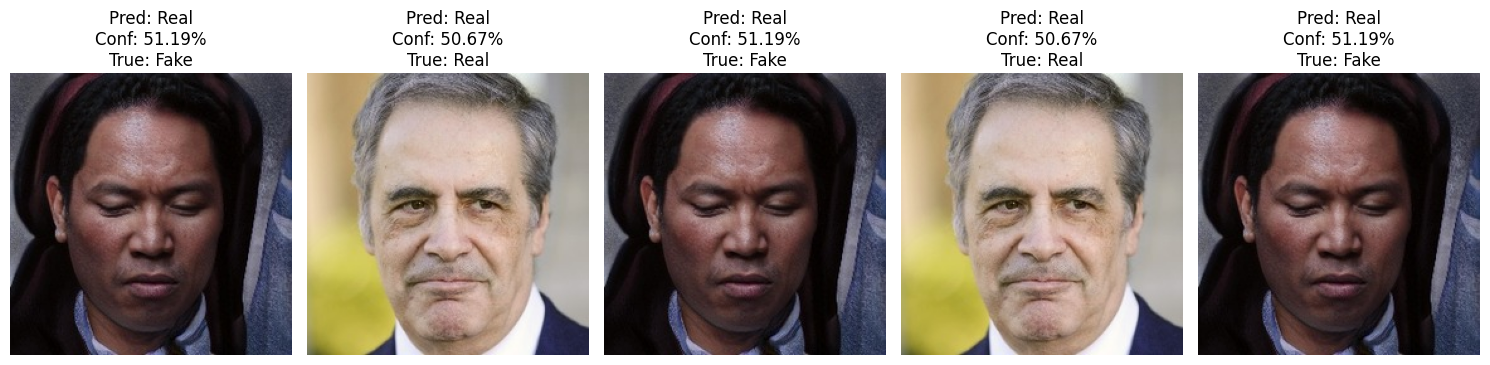

In [15]:
def predict_and_show_samples(generator, num_samples=5):
    generator.reset()
    plt.figure(figsize=(15, 10))

    for i in range(num_samples):
        img_batch, label_batch = next(generator)
        img = img_batch[0]
        true_label = int(label_batch[0])

        pred = model.predict(np.expand_dims(img, axis=0))[0][0]
        pred_label = 'Real' if pred > 0.5 else 'Fake'
        confidence = pred if pred > 0.5 else 1 - pred

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"Pred: {pred_label}\nConf: {confidence:.2%}\nTrue: {'Real' if true_label==1 else 'Fake'}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('/content/sample_predictions.png', dpi=300)
    plt.show()

# Use validation generator for unbiased samples
predict_and_show_samples(validation_generator, num_samples=5)